In [1]:
%matplotlib notebook

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
from pathlib import Path
from natsort import natsorted
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from scipy import stats
from scipy.signal import savgol_filter
import statsmodels.api as sa
import statsmodels.formula.api as sfa

# to import package in parent folder first add the parent folder to path
import sys
import os
packages_path = Path(os.path.dirname(os.path.realpath('__file__'))).parent
sys.path.insert(0, str(packages_path))

import shared_func

In [3]:
home_path = os.getcwd()

filepath = Path(home_path, 'Fig1_data')
savepath = Path(home_path, 'plots')
stat_savepath = Path(home_path, 'stats')

Path(savepath).mkdir(parents=True, exist_ok=True) 
Path(stat_savepath).mkdir(parents=True, exist_ok=True) 

# Hyperscope data (larva) comes with 30 Hz image aquisition frequency
aq_rate = 30

In [4]:
filename = 'Fig1G_noChrimson'
# read the numpy array
data = np.load(Path(filepath, filename + '.npy'))
# and also read the metadata to have everything in one place
with open(Path(filepath, filename + '.txt')) as f:
    metadata = f.read()
    print(metadata)

This numpy array contains the data to create Figure 1J 
which shows response of animals without any UAS-Chrimson transgene
at 47uW/mm2 for 2 seconds. 

Output data is organized the following way:

1st dimension is 600. These are the datapoints 

2nd dimension is 7. These are: Time, Stim, df/f1, df/f2, df/f3, df/f4, df/f5. 
Each df/f is a repeat on the same animal 

3rd dimension is 5, one for each animal 

4th dimension is 1. 

5th dimension is 1.


In [5]:
# Prepare the raw data for plotting
median_per_animal = shared_func.median_per_animal_func(aq_rate=aq_rate, data=data)
# Here stim_intensity is always 0
stim_intensity = 0

# Then, plot the trace plot
fig = plt.figure()
ax = fig.add_subplot(111)

colors = ['slategrey',]

ax.plot(data[:,0,0,stim_intensity, 0], median_per_animal[:,:,stim_intensity, 0], 
        lw=1, zorder=1, color=colors[0], alpha=0.2)
# and plot the mean of the median in bold    # and plot the mean of the median in bold
ax.plot(data[:,0,0,stim_intensity, 0], 
        np.mean(median_per_animal[:,:,stim_intensity, 0], axis=1), 
        lw=4, zorder=1, color=colors[0])

# Plot stimulus
start_stim = np.where(data[:, 1, 0, stim_intensity, 0] > 0.1)[0][0]
stop_stim = np.where(data[:, 1, 0, stim_intensity, 0] > 0.1)[0][-1]
ax.axvspan(data[start_stim, 0, 0, stim_intensity, 0],
           data[stop_stim, 0, 0, stim_intensity, 0],
           lw=0, zorder=0,
           color='k',
           alpha=0.1)
ax.set_xlim(1, 10)

fontprops = fm.FontProperties(size=18)
scalebar_time = AnchoredSizeBar(ax.transData,
                                1, '1 s', 'lower right',
                                pad=0.1,
                                color='black',
                                frameon=False,
                                size_vertical=0.1,
                                fontproperties=fontprops)

scalebar_df = AnchoredSizeBar(ax.transData,
                              0.1, '1 dF/F', 'lower right',
                              pad=0.1,
                              color='black',
                              frameon=False,
                              size_vertical=1,
                              fontproperties=fontprops,
                              label_top=True)

ax.add_artist(scalebar_time)
ax.add_artist(scalebar_df)
ax.legend()
ax.axis('off')

#savename = 'Fig1_G.svg'
#fig.savefig(Path(savepath, savename),            transparent=True)

<IPython.core.display.Javascript object>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1.0, 10.0, -0.4274538700495508, 0.6964045329557056)

In [6]:
# Median values before and during
# For readability explicitly state what is being taken
before_start_index = int(round(start_stim-aq_rate*1)) # one second before start
before_end_index = start_stim

during_start_index = int(round(stop_stim-aq_rate*0.5)) # take half second before the end of the stimulus...
during_end_index = int(round(stop_stim+aq_rate*0.5)) # ...until half second after the end of the stimulus

median_before_stim = np.median(median_per_animal[before_start_index:start_stim, :, :],axis=0)
median_during_stim = np.median(median_per_animal[during_start_index:during_end_index, :, :],axis=0)

<IPython.core.display.Javascript object>


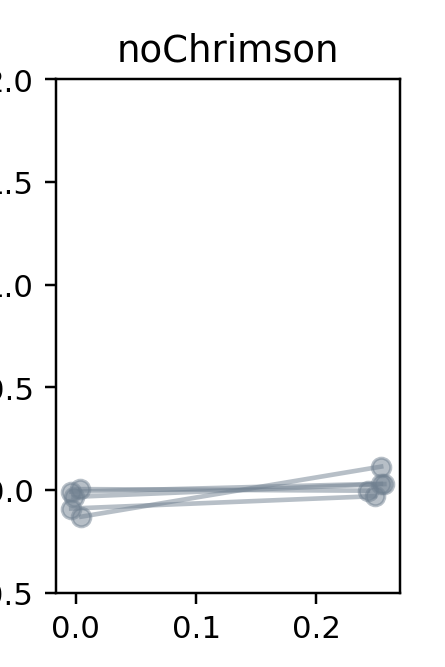

In [7]:
fig = plt.figure(figsize=(2,3))
ax = fig.add_subplot(111)

shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, 
                                       light_intensity=stim_intensity, 
                                       color=colors[0], start_x_position=0, group=0)

ax.set_ylabel('dF/F')
ax.set_title('noChrimson')
ax.set_ylim(-0.5,2)

savename = 'Fig1_G.svg'
fig.savefig(Path(savepath, savename),
            transparent=True)

In [8]:
p_values=[]

# median_before_stim.shape
# (5, 1, 1) # Animal, light intensity, group
shared_func.pairwise_t_tests(median_during_stim[:,0,0], median_before_stim[:,0,0], p_values)

print('Holms-Bonferroni correction:')
shared_func.holms_bonferroni_correction(p_values)

lilliefors: 0.022910209644970855
T-Test
TtestResult(statistic=1.8492996917038824, pvalue=0.1381015066278122, df=4)


Holms-Bonferroni correction:
NOT DIFFERENT!
current p: 0.1381015066278122, current alpha: 0.05


In [9]:
data = [[median_during_stim[:,0,0], median_before_stim[:,0,0]]
       ]

label_list_stat_export = [['During', 'Before']]
savename = 'Fig_1G'

shared_func.export_pairwise_dependent_test(data, label_list_stat_export,
                                           savepath=stat_savepath, savename=savename,
                                           parametric=True)

    Group  n      mean    median       STD       SEM  \
0  During  5  0.027955  0.028784  0.048486  0.021683   
1  Before  5 -0.051511 -0.033398  0.050891  0.022759   

                            95% CI on the mean  DOF statistical test  \
0  (-0.03935411859188242, 0.09526383670389446)  4.0       T-test rel   
1  (-0.12215839839242662, 0.01913701458923811)  NaN              NaN   

   t-statistic   p-value significant  
0       1.8493  0.138102          NO  
1          NaN       NaN         NaN  
